In [18]:
import msgpack as mp
import msgpack_numpy as mpn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *

In [19]:
#data path
_folder_name = "sk11_forward_t0"

_base_pth = r"C:\Users\Sujith\Documents\Projects\skateboard_gui\recording_programs\test_data\single_cam_oct_7"
_pth = os.path.join(_base_pth, _folder_name)


In [20]:
#calibration path
_calib_pth = os.path.join(_base_pth, "calibration7")
_webcam_calib_pth = os.path.join(_calib_pth, "webcam_calibration.msgpack")

#rotation matrix path
_rotmat_pth = r"C:\Users\Sujith\Documents\Projects\skateboard_gui\recording_programs\test_data\single_cam_oct_7\calibration7"
_webcam_rotmat_pth = os.path.join(_rotmat_pth, "webcam_rotmat.msgpack")
_webcam_video_pth = os.path.join(_pth, "webcam_color.msgpack")

#timestamp path
_webcam_timestamp_pth = os.path.join(_pth, "webcam_timestamp.msgpack")
_webcam_calib_pth

'C:\\Users\\Sujith\\Documents\\Projects\\skateboard_gui\\recording_programs\\test_data\\single_cam_oct_7\\calibration7\\webcam_calibration.msgpack'

In [21]:
#open the calibration files
with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

# open rotation matrix and org
    
with open(_webcam_rotmat_pth, "rb") as f:
    webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
    _webcam_rot = next(webcam_rotmat)
    _webcam_org = next(webcam_rotmat)

In [22]:
_w_df = get_ar_pose_data(_webcam_video_pth, _webcam_cam_mat, _webcam_dist, is_color=False, single_file=True, flip_frame=False)

_w_df = add_time_from_file(_w_df, _webcam_timestamp_pth)


returning dataframe


In [23]:
#reading mocap df
_mocap_pth = os.path.join(_base_pth, "mc_data",_folder_name + ".csv")
_m_df, st_time = read_df_csv(_mocap_pth)
#getting center

_m_df["x"] = _m_df["LB_x"] + _m_df["RB_x"] + _m_df["LT_x"] + _m_df["RT_x"]
_m_df["y"] = _m_df["LB_y"] + _m_df["RB_y"] + _m_df["LT_y"] + _m_df["RT_y"]
_m_df["z"] = _m_df["LB_z"] + _m_df["RB_z"] + _m_df["LT_z"] + _m_df["RT_z"]

_m_df["x"] = _m_df["x"] / 4
_m_df["y"] = _m_df["y"] / 4
_m_df["z"] = _m_df["z"] / 4

# _m_df["x"] = _m_df["LT_x"] + _m_df["RT_x"]
# _m_df["y"] = _m_df["LT_y"] + _m_df["RT_y"]
# _m_df["z"] = _m_df["LT_z"] + _m_df["RT_z"]

# _m_df["x"] = _m_df["x"] / 2
# _m_df["y"] = _m_df["y"] / 2
# _m_df["z"] = _m_df["z"] / 2

_m_df = add_datetime_col(_m_df, st_time,_name="seconds")

In [24]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        # _val = _val + translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [25]:

w_df = None

w_df = transform_coordinates_1(_w_df, _webcam_rot, _webcam_org)

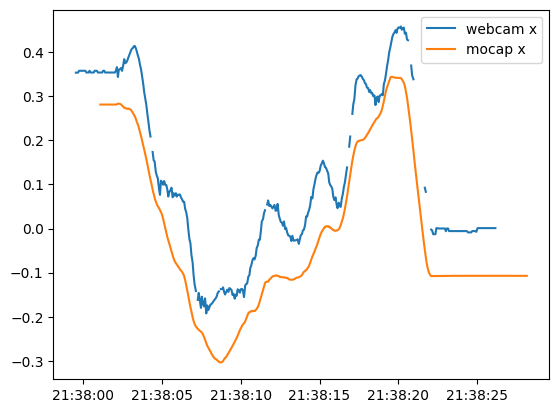

In [26]:

plt.plot(_w_df["time"], w_df["x"], label="webcam x")
plt.plot(_m_df["time"], _m_df["x"], label="mocap x")
plt.legend()

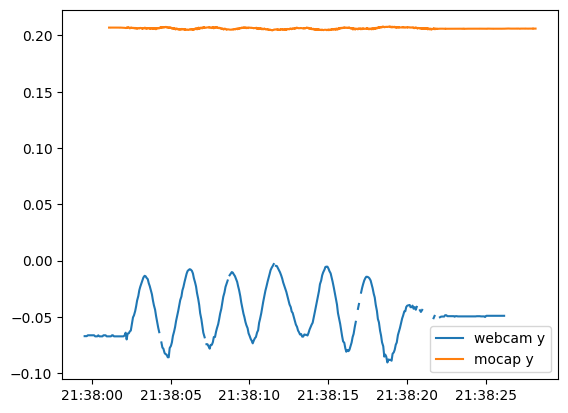

In [27]:

plt.plot(_w_df["time"], _w_df["y"], label="webcam y")
plt.plot(_m_df["time"], _m_df["y"], label="mocap y")
plt.legend()

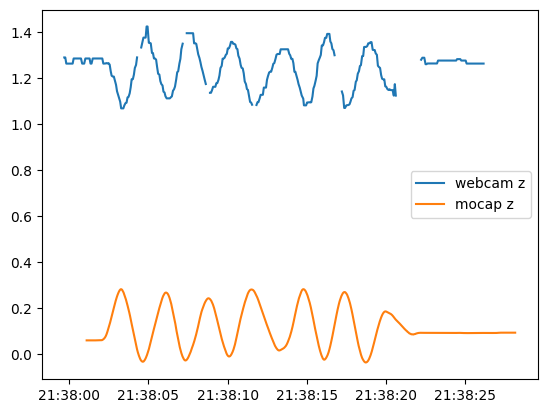

In [28]:

plt.plot(_w_df["time"], _w_df["z"].rolling(3).median(), label="webcam z")
plt.plot(_m_df["time"], _m_df["z"], label="mocap z")
plt.legend()

In [29]:
radius = 47.5/1000
lx = 79 #half of the distance between the wheels
ly = 122.5/2

In [30]:
_sk_csv_pth = os.path.join(_pth, "imu01.csv")
_sk_df = pd.read_csv(_sk_csv_pth)


In [31]:
_sk_df = set_zero(_sk_df)
_sk_df, _ang_column = get_angular_velocity(_sk_df)
_sk_df, _ = get_directional_velocity(_sk_df, _ang_column, radius, lx, ly)
_sk_df, _ = get_position(_sk_df)


In [32]:
_sk_df["sys_time"] = pd.to_datetime(_sk_df["sys_time"])


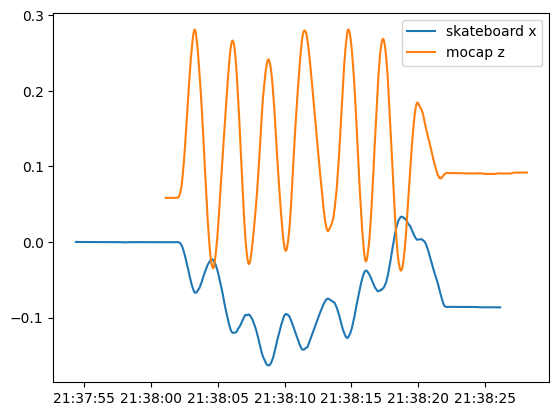

In [33]:
plt.plot(_sk_df["sys_time"],_sk_df["x_val"], label="skateboard x")
plt.plot(_m_df["time"], _m_df["z"], label="mocap z")
plt.legend()


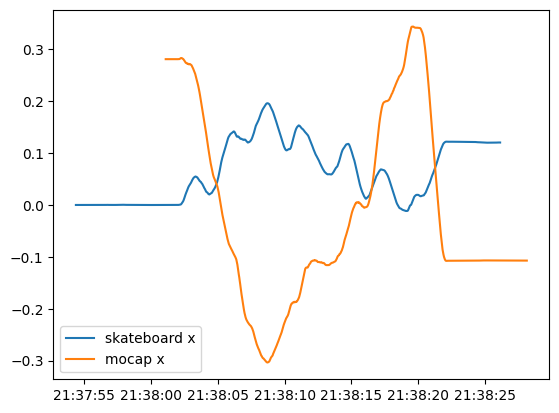

In [34]:
plt.plot(_sk_df["sys_time"],_sk_df["y_val"], label="skateboard x")
plt.plot(_m_df["time"], _m_df["x"], label="mocap x")
plt.legend()
